In [3]:
# this is copy of embed.ipynb
# the idea is to move through all the pre-embedding data, 
# and compute the tf and idf values (by url or domain)
# using the Glove vocab

# standard library
import time
import json
import re
import numpy as np
import urllib

import sentence_transformers
from sentence_transformers.models.tokenizer import WhitespaceTokenizer
from sentence_transformers.models import WordEmbeddings

from scipy.linalg import norm

import matplotlib.pyplot as plt

# Read in data

In [2]:
dirname = "/Users/cschmidt/delomore/delomore-parse-output/output/"

In [5]:
alljson = { "collections" : {},
            "products" : {},
            "homepage" : [],
            "about" : [],
            "pages" : [],
            "blogs" : [],
          }

In [6]:
queryfile = "/Users/cschmidt/otherrepos/delomore-dataset/query-domains.tsv"
querydomain = open(queryfile, "rt").readlines()
querydomain = [l.rstrip().split("\t") for l in querydomain]

# get the set of display domains
gooddomains = set()

for (query, displaydomain, domain) in querydomain:
    gooddomains.add(displaydomain)
    
print(len(gooddomains))

150


# Get our Glove vocabulary

In [24]:
# lets get out vocab from the large Glove model
# in the "vocab" entry of this json fible
# take out PADDING_TOKEN, maybe others?
glove = open("/Users/cschmidt/otherrepos/average_word_embeddings_glove.840B.300d/0_WordEmbeddings/whitespacetokenizer_config.json", "rt").read()

In [25]:
glovejson = json.loads(glove)

In [26]:
glovejson.keys()

dict_keys(['vocab', 'stop_words', 'do_lower_case'])

In [27]:
vocab = glovejson["vocab"]
print(len(vocab))

2196017


In [81]:
# given the index in vocab, give us the words back
idx2word = { idx: w for (idx,w) in enumerate(vocab) }

In [28]:
# see if we have other values like PADDING_TOKEN
s = "PADDING_TOKEN"
pattern = re.compile('^[A-Z][A-Z_]+$')

weird = []

for v in vocab:
    match = pattern.search(v)
    if match and "_" in v:
        weird.append(v)

In [29]:
# I guess we don't care other than PADDING_TOKEN
weird[:10]

['PADDING_TOKEN',
 'COLOR_NAME',
 'SIZE_NAME',
 'RECOLORED_IMAGE',
 'HKEY_LOCAL_MACHINE',
 'MASON_GROUP_NAME',
 'O_O',
 'SEQUENCE_NO',
 'T_T',
 'COLOR_CODE']

In [30]:
vocabSet = set(vocab)
vocabSet.remove(s)
print(len(vocabSet))

2196016


In [194]:
# lets compare to the original file
s = "09286 0.2437 -0.35354 0.17792 -0.77452 -0.022218 -0.19694 0.027929 0.72023 -0.78183 -0.51935 0.093575 0.018988 -0.55911 -0.37718 -0.19112 -0.62838 -0.009131 -0.2324 -0.19366 -0.019515 0.96971 0.43246 -0.056218 0.41794 0.011944 0.17478 -0.039223 0.76286 0.3884 0.61643 -0.28975 -0.47308 0.27847 0.65565 0.071213 -0.10962 -0.24403 0.45842 -0.55064 -0.027161 -0.1487 0.44118 0.43395 -0.3965 0.14803 0.11134 0.28239 0.30327 0.19846 0.22784 -0.3097 -0.15669 -0.57701 0.56791 -0.29641 0.2314 0.21675 -0.63885 -0.49087 0.034753 -0.20009 0.19368 -0.15374 -0.16039 0.22898"

# get everything up to the first space
def getinitialword(s):
    return s[:s.find(" ")]

glovefile = "/Users/cschmidt/otherrepos/idf-glove/glove/glove.840B.300d.txt"

start_time = time.time()
glovevocab = [getinitialword(l) for l in open(glovefile, 'rt').readlines()]
print("time:", time.time() - start_time)

time: 31.532246828079224


In [195]:
glovevocabSet = set(glovevocab)

In [196]:
len(glovevocab)

2196017

In [197]:
# oh, there's one duplicate here
len(glovevocabSet)

2196016

In [37]:
len(vocab)

2196017

In [68]:
# huh, these dupe is this stupid thing
cnt = {}
for v in glovevocab:
    cnt[v] = cnt.get(v,0) + 1
for v, c in cnt.items():
    if c > 1:
        print(v,c)

���������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������� 2


In [32]:
glovevocab[:10]

[',', '.', 'the', 'and', 'to', 'of', 'a', 'in', '"', ':']

In [35]:
glovevocab[-10:]

['work.Like',
 'working.So',
 'wried',
 'wwent',
 'xalisae',
 'xtremecaffeine',
 'yildirim',
 'z/28',
 'zipout',
 'zulchzulu']

In [33]:
vocab[:10]

['PADDING_TOKEN', ',', '.', 'the', 'and', 'to', 'of', 'a', 'in', '"']

In [62]:
# the sets are the same, without the PADDING_TOKEN
vocabSet == glovevocabSet

True

In [83]:
# can load it in directly
# note that it ignores stopwords
tokenizer = WhitespaceTokenizer().load("/Users/cschmidt/otherrepos/average_word_embeddings_glove.840B.300d/0_WordEmbeddings/")

In [90]:
# tokenize with our WhitespaceTokenizer, 
# but then return the actual words in a list
def tokenizeWords(s):
    return [idx2word[idx] for idx in tokenizer.tokenize(s)]

In [91]:
words = tokenizeWords("cow white")
print(words)
# stop words dissappear
words = tokenizeWords("the cow is white")
print(words)
# retains case, drops punctuation
words = tokenizeWords("the Cow is white!")
print(words)

['cow', 'white']
['cow', 'white']
['Cow', 'white']


In [136]:
tokenizeWords("50 beanie package")

['50', 'beanie', 'package']

In [137]:
tokenizeWords("8.5")

['8.5']

In [95]:
# get the data from wikipedia_doc_frequencies.txt
wikidffile = "/Users/cschmidt/otherrepos/idf-glove/wikipedia_doc_frequencies.txt"
wikidoc = open(wikidffile, "rt").readlines()
# overall number of documents on the first line
N = int(wikidoc[0].rstrip())
print(N)
# skip N
wikidoc = wikidoc[1:]
wikidoc = [l.rstrip().split("\t") for l in wikidoc]
# make a dict
wikidf = { w : int(c) for (w,c) in wikidoc}

5310458


In [176]:
# compute our idf term, 
# for just those words in the vocabSet
# add 1 so still works if no values ??
idf = { w : np.log(N/c) for (w,c) in wikidf.items() if w in vocabSet}
len(idf)

550935

In [108]:
np.log(N/2)

14.792041461292705

In [177]:
# so a word with a df of 2 is worth 430 times as much as the most common
max(idf.values())/min(idf.values())

430.5509858088449

In [178]:
# not great coverage here
# could do a smoothed version with + 1
found = 0
missing = 0
for v in vocabSet:
    if v in wikidf:
        found += 1 
    else:
        missing += 1
print("found:", found)
print("missing:", missing)

found: 550935
missing: 1645081


In [148]:
dirname

'/Users/cschmidt/delomore/delomore-parse-output/output/'

In [157]:
# note that collections just have an 'og:title' and 'product-handles'

doccnt = 0
# how many documents does the word appear in
wordcnt = {}

def getTokenizedText(d):
    
    text = ""
    
    for field in ["og:title", "og:site_name", "og:description"]:
        if field in d:

            # is occasionally a list, just use first then 
            if type(d[field]) == list:
                text += d[field][0] + ". "
            else:
                text += d[field] + ". "
                
    words = tokenizeWords(text)
    
    global wordcnt
    # eliminate duplicates with set
    # at most get +1 for this page
    for w in set(words):
        wordcnt[w] = wordcnt.get(w,0) + 1
    
    global doccnt
    doccnt += 1 
    
    
start_time = time.time()

# Use each page as a document here
# 00000 to 14222
for chunk in range(14223):
    
    if chunk % 100 == 0:
        print(chunk, doccnt, time.time() - start_time)
    
    chunkname = str(chunk).rjust(5, '0') + ".tsv"

    filename = dirname + chunkname
    data = [l.rstrip().split("\t") for l in open(filename, 'rt').readlines()]    

    for domain,displaydomain,url,alljson in data:

        # convert to json
        j = json.loads(alljson)

        # are 4 possible kinds of pages to use
        if "about" in j:
            # is a possibly empty list
            for d in j["about"]:
                getTokenizedText(d)

        # note that collections just have an 'og:title' and 'product-handles'
        if "collections" in j:
            # is a dict with handles
            for handle, d in j["collections"].items():
                getTokenizedText(d)

        # has handles
        if "products" in j:
            # is a dict with handles
            for handle, d in j["products"].items():
                getTokenizedText(d)

        # has handles
        if "homepage" in j:
            # is a possibly empty list
            for d in j["homepage"]:
                getTokenizedText(d)

print(doccnt)

0 0 0.0002498626708984375
100 460359 21.50938606262207
200 918534 42.80574584007263
300 1367004 63.594740867614746
400 1814600 85.54495286941528
500 2267401 107.77748990058899
600 2722451 130.41981482505798
700 3175132 151.53958082199097
800 3634600 173.82817697525024
900 4082035 197.6442220211029
1000 4536857 219.11221480369568
1100 4988963 240.36608791351318
1200 5429577 261.2754759788513
1300 5876201 282.16024684906006
1400 6335477 304.24163579940796
1500 6789822 325.71556305885315
1600 7238725 347.39124584198
1700 7698314 368.48858094215393
1800 8150358 389.7115259170532
1900 8600183 410.9652979373932
2000 9059777 431.9005198478699
2100 9518759 453.6181318759918
2200 9959376 474.6524107456207
2300 10400917 497.4141798019409
2400 10854935 518.7216777801514
2500 11311368 540.1843667030334
2600 11771801 561.5627839565277
2700 12215970 582.2565467357635
2800 12677880 603.4760377407074
2900 13143471 625.671737909317
3000 13591367 646.5080478191376
3100 14041258 668.250777721405
3200 144

In [182]:
print(doccnt)
print(len(wordcnt))

64886566
1305349


In [186]:
# ok, so how many of thoese words are in vocab
# oh, the tokenizer drops all those words not in in vocab

# only keep those in at least 2 documents
# use our local doccnt
idf2 = { w : np.log(doccnt/c) for (w,c) in wordcnt.items() if c >= 2}

mywordset = set(wordcnt2)
print(len(mywordset))
# we can also use the df from idf that are also in vocab
either = mywordset | (set(idf.keys()) & vocabSet)
print(len(either))
print()

print("idf2:", len(idf2))
# now supplement with any values of idf that aren't already in idf2
# however, we want to use the existing value if it is there
for (w,v) in idf.items():
    if w not in idf2:
        idf2[w] = v
print("after idf2:", len(idf2))

assert len(idf2) == len(either)

1116700
1308084

idf2: 1116700
after idf2: 1308084


In [188]:
# the duplicate row donsn't have a weight, so won't end up in file
duplicate = "����������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������"
duplicate in idf2

False

In [212]:
# lets output our idf2 values while we're at it
sortedidf2 = sorted([(v,w) for (w,v) in idf2.items()], reverse=True)

In [214]:
# and save to the disk
with open("/Users/cschmidt/otherrepos/idf-glove/glove/idf2.tsv", "wt") as out:
    for v,w in sortedidf2:
        out.write(str(v) + "\t" + w + "\n")

In [13]:
# load it back in, so we can try clipping values
sortedidf2 = []
justscores = []
with open("/Users/cschmidt/otherrepos/idf-glove/glove/idf2.tsv", "rt") as f:
    for line in f:
        idfval, word = line.rstrip().split("\t")
        sortedidf2.append((float(idfval), word))
        justscores.append(float(idfval))

In [14]:
sample = [s for i,s in enumerate(justscores) if i%100 == 0]
print(len(sample))

13081


In [21]:
# see some values 
for i in range(len(sortedidf2)):
    if i % 20000 == 0:
        print(i, sortedidf2[i])

0 (17.29500398431037, '￡')
20000 (17.29500398431037, 'kearns')
40000 (17.29500398431037, 'Venao')
60000 (17.29500398431037, 'Morganthaler')
80000 (17.29500398431037, 'Durdy')
100000 (17.29500398431037, '4L4')
120000 (16.889538876202206, 'rerip')
140000 (16.889538876202206, 'Woollam')
160000 (16.889538876202206, 'Laelaps')
180000 (16.889538876202206, 'Adanson')
200000 (16.601856803750422, 'road.It')
220000 (16.601856803750422, 'Sixty-second')
240000 (16.601856803750422, 'CuteCircuit')
260000 (16.378713252436214, 'table.If')
280000 (16.378713252436214, 'Rainbowbrite')
300000 (16.378713252436214, '76.35')
320000 (16.19639169564226, 'bandmember')
340000 (16.19639169564226, 'Bokeem')
360000 (16.042241015815, 'beta-blockers')
380000 (16.042241015815, '68815')
400000 (15.908709623190479, 'Pelléas')
420000 (15.790926587534095, 'mid-1968')
440000 (15.790926587534095, '30297')
460000 (15.685566071876268, 'Cober')
480000 (15.590255892071944, 'Gizmoz')
500000 (15.503244515082315, 'Folkes')
520000 

In [15]:
# want to clip the very uncommon ones to the same value, so they don't 
# dominate the mid range terms
max(sample)

17.29500398431037

13.097802036648561


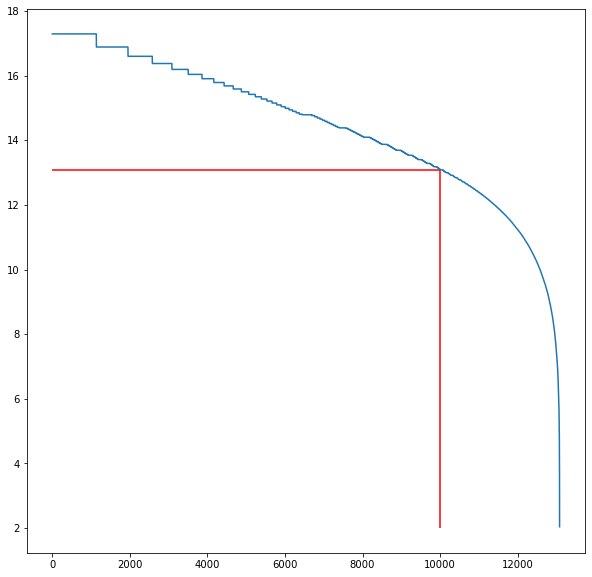

In [41]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(sample)
maxval = justscores[1000000]
print(maxval)
plt.vlines(x=10000,ymin=2, ymax=maxval, color="red")
plt.hlines(y=maxval,xmin=0, xmax=10000, color="red")

In [47]:
# might as well scale it so the max is 1.0 while we're at it
sortedidf3 = [(min(idfval,maxval)/maxval, w) for idfval,w in sortedidf2]
idf3 = { w : s for (s,w) in sortedidf3}
justscores = [s for (s,w) in sortedidf3]

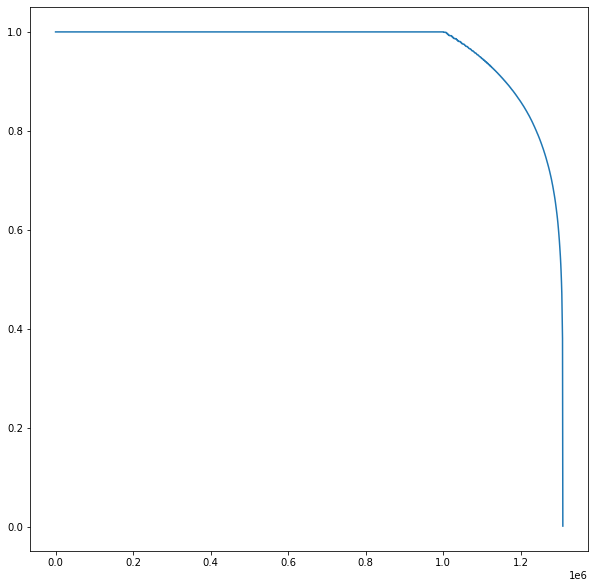

In [48]:
# this makes it clear it is about downweighting common words
# not making the more obscure stuff super important
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(justscores)
# maxval = justscores[1000000]
# print(maxval)
# plt.vlines(x=10000,ymin=2, ymax=maxval, color="red")
# plt.hlines(y=maxval,xmin=0, xmax=10000, color="red")

In [51]:
# now update our vectors file, 
# only keeping those rows in idf3,
# and multiplying each row by the idf value

glovefile =   "/Users/cschmidt/otherrepos/idf-glove/glove/glove.840B.300d.txt"
weightedout = "/Users/cschmidt/otherrepos/idf-glove/glove/glove.840B.300d.weighted.txt"

# get everything up to the first space
def getinitialword(s):
    return s[:s.find(" ")]

out = open(weightedout, "wt")

written = 0

start_time = time.time()
for line in open(glovefile, 'rt'):
    # this will be a bit faster, since most won't be in idf3
    gw = getinitialword(line)
    # only keep if have a valid weight
    if gw in idf3:
        vec = line.rstrip().split(" ")
        assert vec[0] == gw
        # drop the word
        vec = vec[1:]
        vec = np.array([float(x) for x in vec])
        # need to normalize
        vec /= norm(vec)
        # and multiply by idf3
        vec *= idf3[gw]
        out.write(gw + " " + " ".join([str(a) for a in vec]) + "\n")
        written += 1
        
print("time:", written, time.time() - start_time)
out.close()

time: 1308084 471.6110429763794


In [52]:
# covert to the right internal format
model = WordEmbeddings.from_text_file(weightedout)

Load Word Embeddings: 1308084Embeddings [03:17, 6622.58Embeddings/s]


In [53]:
# and dump it to disk
model.save("/Users/cschmidt/otherrepos/idf-glove/glove/weightedoutput")

In [54]:
print(idf3["weighted"])
print(idf3["blanket"])

0.6015102961325726
0.4681569843589681


In [57]:
# just look at an example
test = ["Bearaby",
"weighted",
"blanket",
"made",
"without",
"artificial",
"fillers",
"or",
"synthetic",
"fabrics",
"Naturally",
"heavy",
"cooling",
"and",
"hand-knit",
"with",
"organic",
"materials",
"Buy",
"weighted",
"blanket",
"now"]
        
for w in test:
    print(w, idf3.get(w,0.0))

Bearaby 0.0
weighted 0.6015102961325726
blanket 0.4681569843589681
made 0.142383046559281
without 0.21456753897446318
artificial 0.49430935445294394
fillers 0.6047332018048627
or 0.10244944076170853
synthetic 0.4641162106970325
fabrics 0.4135655872428576
Naturally 0.5281091853425119
heavy 0.39697307167562434
cooling 0.5129785034263893
and 0.02363397877630451
hand-knit 0.7848104235398403
with 0.05770230716883812
organic 0.3493871347665926
materials 0.3780104508580741
Buy 0.30636770966974847
weighted 0.6015102961325726
blanket 0.4681569843589681
now 0.16811524275366985
